# SASRec

이번 실습에서는 SASRec(Kang et al, https://arxiv.org/abs/1808.09781) 을 이해하고 구현해보겠습니다.
SASRec은 자연어 처리에서 많이 사용되는 Transformer를 sequential recommendation에 적용한 모델입니다.
Transformer는 자연어 처리 뿐만 아니라 SASRec과 같이 추천 시스템 또는 영상 처리에서도 많이 사용되는 모델으로 Transformer 소개 논문을 읽어보시기를 추천 드립니다. (https://arxiv.org/abs/1706.03762)

이번 실습을 통해서 sequential recommendation에서 어떻게 Transformer를 사용하였는지 살펴보겠습니다.

(참고 코드: https://github.com/kang205/SASRec, https://github.com/pmixer/SASRec.pytorch)

## Model overview

먼저 SASRec의 overview부터 살펴 보겠습니다. SASRec은 Transformer의 decoder 구조를 사용한 sequential recommendation 모델입니다. SASRec은 Transformer의 주 component인 self-attention layer(scaled dot-product attention, multi-head attention)와 point-wise feed-forward network를 사용합니다. 아래의 그림에서 SASRec의 overview를 확인할 수 있습니다. 각 item은 embedding layer를 거치고 self-attention layer와 point-wise feed-forward network으로 이루어진 블럭을 거쳐 다음에 사용할 item을 예측하게 됩니다. 본 예제를 통해 각 component의 구현을 살펴봅시다.

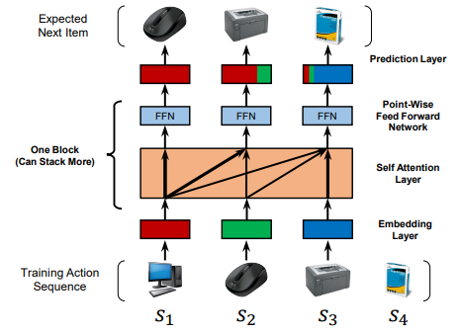

## Modules

In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

## Hyper-parameters

In [2]:
# model setting
max_len = 50
hidden_units = 50
num_heads = 1
num_layers = 2
dropout_rate=0.5
num_workers = 1
device = 'cuda' # gpu 환경 확인 필요

# training setting
lr = 0.001
batch_size = 128
num_epochs = 200

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [3]:
# !wget <대회 데이터 URL>
# !tar -xf data.tar.gz

## Data preprocessing

본 예제에서는 MovieLens dataset을 사용합니다. MovieLens dataset을 활용하여 sequential recommendation을 할 수 있도록 전처리를 해줍시다. 

In [4]:
############# 중요 #############
# data_path는 사용자의 디렉토리에 맞게 설정해야 합니다.
data_path =  "/opt/ml/input/data/train/train_ratings.csv"
df = pd.read_csv(data_path)

item_ids = df['item'].unique()
user_ids = df['user'].unique()
num_item, num_user = len(item_ids), len(user_ids)
num_batch = num_user // batch_size

# user, item indexing
item2idx = pd.Series(data=np.arange(len(item_ids))+1, index=item_ids) # item re-indexing (1~num_item), 0은 mask
user2idx = pd.Series(data=np.arange(len(user_ids)), index=user_ids) # user re-indexing (0~num_user-1)

# dataframe indexing
df = pd.merge(df, pd.DataFrame({'item': item_ids, 'item_idx': item2idx[item_ids].values}), on='item', how='inner')
df = pd.merge(df, pd.DataFrame({'user': user_ids, 'user_idx': user2idx[user_ids].values}), on='user', how='inner')
df.sort_values(['user_idx', 'time'], inplace=True)
del df['item'], df['user'] 

# train set, valid set 생성
users = defaultdict(list) # defaultdict은 dictionary의 key가 없을때 default 값을 value로 반환
user_train = {}
user_valid = {}
for u, i, t in zip(df['user_idx'], df['item_idx'], df['time']):
    users[u].append(i)

for user in users:
    user_train[user] = users[user][:-1]
    user_valid[user] = [users[user][-1]]

print(f'num users: {num_user}, num items: {num_item}')

num users: 31360, num items: 6807


In [8]:
# for training, data sampling
def random_neg(l, r, s):
    # log에 존재하는 아이템과 겹치지 않도록 sampling
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t

def sample_batch(user_train, num_user, num_item, batch_size, max_len):
    def sample():

        user = np.random.randint(num_user)  # user를 임의로 선택

        # 미리 max_len에 해당하는 array 생성, zero padding
        seq = np.zeros([max_len], dtype=np.int32)
        pos = np.zeros([max_len], dtype=np.int32)
        neg = np.zeros([max_len], dtype=np.int32)
        nxt = user_train[user][-1]
        idx = max_len - 1

        # negative sample은 train sequence에 없는 item 사용
        train_item = set(user_train[user])
        for i in reversed(user_train[user][:-1]):
            # 미리 정의된 sequence를 역순으로 채움, ex: seq = [0,0,0,1,2,3] (0은 pad)
            seq[idx] = i
            pos[idx] = nxt
            if nxt != 0:
                neg[idx] = random_neg(1, num_item + 1, train_item)
            nxt = i
            idx -= 1
            if idx == -1: break
        return (user, seq, pos, neg)
    user, seq, pos, neg = zip(*[sample() for _ in range(batch_size)])
    user, seq, pos, neg = np.array(user), np.array(seq), np.array(pos), np.array(neg)
    return user, seq, pos, neg

## Model
SASRec의 model 구조는 Transformer의 decoder를 사용합니다. SASRec의 구현을 위해 Transformer의 각 component를 살펴봅시다.

### Self attention
기존 자연어 처리 모델들과 달리 Transformer는 scaled dot-product attention을 사용하여 self-attention을 취해 단어간의 관계 등을 모델링합니다. 이때 self-attention의 계산을 위하여 한 단어의 embedding을 query, key, value로 나누고, query와 key의 곱을 통하여 attention weight를 결정합니다. Self-attention을 통하여 RNN과 달리 문장의 처리를 동시에 할 수 있다는 큰 장점이 있습니다.

그리고 연산량의 감소 및 여러 측면의 attention을 고려하기 위해 하나의 item이 표현하는 embedding을 여러 개로 나누어 scaled-dot product attention을 여러 개로 head로 나누어 수행합니다. 이를 multi-head attention이라고 부릅니다. Self-attention layer를 구성하는 scaled-dot product attention과 multi-head attention은 아래의 그림에서 확인할 수 있습니다.

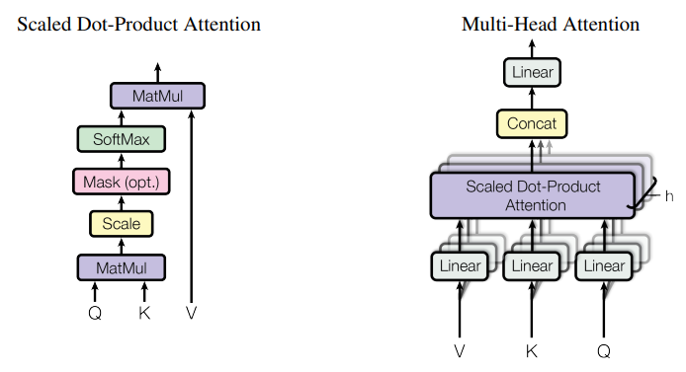

In [9]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate) # TODO1: dropout rate를 hyper parameter로 사용하여 dropout layer를 구현하세요.

    def forward(self, Q, K, V, mask):
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate) # TODO2: ScaledDotProductAttention class를 사용하여 attention layer를 구현하세요.
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)
        
        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) 
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        output, attn_dist = self.attention(Q, K, V, mask)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() 
        output = output.view(batch_size, seqlen, -1)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)
        return output, attn_dist

### Position-wise Feed Forward Network
Position-wise Feed Forward Network는 multi-head attention의 출력의 각 position에 feed forward network를 적용하기 위한 Fully connected feed forward network입니다.

In [10]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output

위에서 구현한 module을 종합하여 SASRec의 block을 만들 수 있습니다.

In [11]:
class SASRecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist

### Positional Encoding
Transformer는 position에 대한 정보를 input의 순서로부터 얻을 수 없습니다. 따라서 위치에 대한 정보를 input에 함께 반영해주어야 합니다. 순서 반영을 위하여 Transformer 모델은 input embedding에 positional encoding 더해 input으로 사용합니다. SASRec에서는 sinusoidal function을 사용하는 기존의 Transformer와 달리 학습 가능한 파라미터로 positional encoding을 모델링합니다. 이는 item embedding과 마찬가지로 간단히 pytorch의 nn.Embedding을 통해 구현할 수 있습니다. 

### SASRec
위에서 구현한 class를 가지고 SASRec 모델을 구현해 봅시다. SASRec 논문을 따라 구현한 예제입니다.

In [12]:
class SASRec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, maxlen, dropout_rate, device):
        super(SASRec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx=0) # TODO3: item embedding을 생성하세요. (padding index 고려 필요)
        self.pos_emb = nn.Embedding(maxlen, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([SASRecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
    
    def feats(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device))
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))
        seqs = self.emb_layernorm(self.dropout(seqs))
        
        # masking 
        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).unsqueeze(1) # TODO4: log_seqs=0인 경우 masking이 필요합니다. 해당 조건을 만족하는 mask를 구현하세요.
        # 참고 unsqueeze operation을 통해 mask_pad와 mask_time의 차원을 맞춰주는 과정이 필요합니다.        
        mask_time = (1 - torch.triu(torch.ones((1, 1, seqs.size(1), seqs.size(1))), diagonal=1)).bool() # sequence의 순서를 고려
        mask = (mask_pad & mask_time).to(self.device)
        for block in self.blocks: 
            seqs, attn_dist = block(seqs, mask)
        return seqs
    
    def forward(self, log_seqs, pos_seqs, neg_seqs):
        # 학습에 사용 
        feats = self.feats(log_seqs) # TODO5: Transformer를 사용해서 token 별 연산을 수행하세요.
        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.device))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.device))
        
        pos_logits = (feats * pos_embs).sum(dim=-1)
        neg_logits = (feats * neg_embs).sum(dim=-1)
        return pos_logits, neg_logits
    
    def predict(self, log_seqs, item_indices):
        # evaluation에 사용
        final_feats = self.feats(log_seqs)[:, -1, :]
        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.device))
        logits = item_embs.matmul(final_feats.unsqueeze(-1)).squeeze(-1)
        return logits

## Training

In [13]:
# setting
model = SASRec(num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device)
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# training
for epoch in range(1, num_epochs + 1):
    tbar = tqdm(range(num_batch))
    for step in tbar: # num_batch만큼 sampling
        user, seq, pos, neg = sample_batch(user_train, num_user, num_item, batch_size, max_len)
        pos_logits, neg_logits = model(seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=device), torch.zeros(neg_logits.shape, device=device)
        
        optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        loss.backward()
        optimizer.step()
        
        tbar.set_description(f'Epoch: {epoch:3d}| Step: {step:3d}| Train loss: {loss:.5f}')

Epoch:   1| Step: 244| Train loss: 2.12913: 100%|██████████| 245/245 [00:11<00:00, 22.17it/s]
Epoch:   2| Step: 244| Train loss: 1.28087: 100%|██████████| 245/245 [00:11<00:00, 21.85it/s]
Epoch:   3| Step: 244| Train loss: 0.99788: 100%|██████████| 245/245 [00:10<00:00, 22.95it/s]
Epoch:   4| Step: 244| Train loss: 0.94634: 100%|██████████| 245/245 [00:10<00:00, 22.57it/s]
Epoch:   5| Step: 244| Train loss: 0.87426: 100%|██████████| 245/245 [00:10<00:00, 22.92it/s]
Epoch:   6| Step: 244| Train loss: 0.88211: 100%|██████████| 245/245 [00:10<00:00, 22.80it/s]
Epoch:   7| Step: 244| Train loss: 0.91404: 100%|██████████| 245/245 [00:11<00:00, 21.92it/s]
Epoch:   8| Step: 244| Train loss: 0.89970: 100%|██████████| 245/245 [00:11<00:00, 21.58it/s]
Epoch:   9| Step: 244| Train loss: 0.87467: 100%|██████████| 245/245 [00:10<00:00, 22.66it/s]
Epoch:  10| Step: 244| Train loss: 0.91163: 100%|██████████| 245/245 [00:10<00:00, 23.81it/s]
Epoch:  11| Step: 244| Train loss: 0.91725: 100%|██████████|

## Evaluate

In [15]:
model.eval()

NDCG = 0.0 # NDCG@10
HIT = 0.0 # HIT@10

num_item_sample = 100
num_user_sample = 1000
users = np.random.randint(0, num_user, num_user_sample) # 1000개만 sampling 하여 evaluation
for u in users:
    seq = user_train[u][-max_len:]
    rated = set(user_train[u] + user_valid[u])
    item_idx = user_valid[u] + [random_neg(1, num_item + 1, rated) for _ in range(num_item_sample)]

    with torch.no_grad():
        predictions = -model.predict(np.array([seq]), np.array(item_idx))
        predictions = predictions[0]
        rank = predictions.argsort().argsort()[0].item()

    if rank < 10: # @10
        NDCG += 1 / np.log2(rank + 2)
        HIT += 1
print(f'NDCG@10: {NDCG/num_user_sample}| HIT@10: {HIT/num_user_sample}')

NDCG@10: 0.50208957834434| HIT@10: 0.786
